# Cochleagram generation in pytorch

### Adapted from  https://github.com/jenellefeather/chcochleagram.git

In [ ]:
!pip install colorednoise

In [ ]:
!pip uninstall ipykernel -y
!pip install ipykernel==5.5.6

Found existing installation: ipykernel 6.17.1
Uninstalling ipykernel-6.17.1:
  Successfully uninstalled ipykernel-6.17.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==6.17.1, but you have ipykernel 5.5.6 which is incompatible.


In [ ]:
!pip install scipy --upgrade

In [ ]:
# prompt: Get scipy version

import scipy
print(scipy.__version__)


1.15.2


In [ ]:
# Install the repo -- not necessary if running locally but useful for colab :)
!pip install git+https://github.com/jenellefeather/chcochleagram.git

  Cloning https://github.com/jenellefeather/chcochleagram.git to /tmp/pip-req-build-x8a62vzg
  Running command git clone --filter=blob:none --quiet https://github.com/jenellefeather/chcochleagram.git /tmp/pip-req-build-x8a62vzg
  Resolved https://github.com/jenellefeather/chcochleagram.git to commit c634ca85566c3f595480cb3e9a8c0f5c6236d311
  Preparing metadata (setup.py) ... done
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached jupyterlab-4.3.6-py3-none-any.whl.metadata (16 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5

In [ ]:
import chcochleagram
import torch as ch
import numpy as np
import librosa
%matplotlib inline
import matplotlib.pylab as plt

# Set cochleagram parameters and build the cochleagram operation

The steps of the cochleagram operations are outlined below for an example cochleagram.

### Define the cochlear filters

Text(0, 0.5, 'Filter Magnitude')

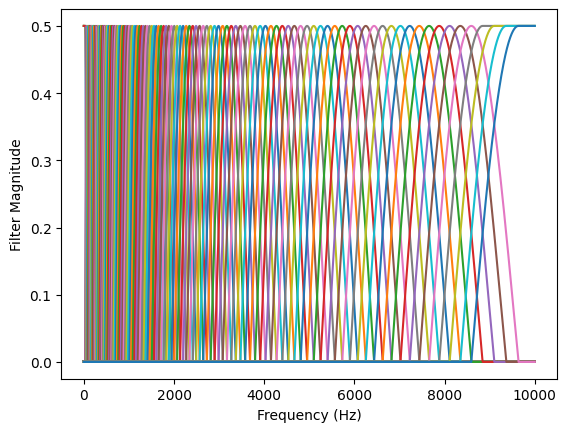

In [ ]:
### Args used for multiple stages of the cochleagram operations
signal_size = 32000 # Length of the input audio signal (currently must be fixed, due to filter construction)
sr = 20000 # Sampling rate of the input audio
pad_factor = 1.25 # Zero padding applied to the waveform, so the end signal is length pad_factor*signal_length
use_rfft = True # Whether to use rfft operations when appropriate (recommended)

### Define the cochlear filters using ERBCosFilters.
# These are the arguments used for filter construction of ERBCosFilters. See helpers/erb_filters.py for
# more documentation.
half_cos_filter_kwargs = {
    'n':30, # Number of filters to evenly tile the space
    'low_lim':52, # Lowest center frequency for full filter (if lowpass filters are used they can be centered lower)
    'high_lim':8844, # Highest center frequency
    'sample_factor':4, # Positive integer that determines how densely ERB function will be sampled
    'full_filter':False, # Whether to use the full-filter. Must be False if rFFT is true.
}
# These arguments are for the CochFilters class (generic to any filters).
coch_filter_kwargs = {'use_rfft':use_rfft,
                      'pad_factor':pad_factor,
                      'filter_kwargs':half_cos_filter_kwargs}

# This (and most) cochleagrams use ERBCosFilters, however other types of filterbanks can be
# constructed for linear spaced filters or different shapes. Make a new CochlearFilter class for
# these.
filters = chcochleagram.cochlear_filters.ERBCosFilters(signal_size,
                                                       sr,
                                                       **coch_filter_kwargs)

### Look at the filters
# Filters are in form [filter_idx, frequency, (real_value, complex_value)] where for ERB filters
# the complex component is 0. Newer versions of pytorch have complex types, but complex values are
# represented with an extra dimension for now.
for f_idx in range(filters.coch_filters.shape[0]):
    plt.plot(filters.filter_extras['freqs'], filters.coch_filters[f_idx,:,0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter Magnitude')

### Define the other cochleagram components.
* Envelope extraction
* Downsampling operation
* Compression applied to the envelopes

***In the following, one might need to change signal.kaiser to signal.windows.kaiser in the chcochleargram/downsampling.py Line 78***

In [ ]:
### Define an envelope extraction operation
# Use the analytic amplitude of the hilbert transform here. Other types of envelope extraction
# are also implemented in envelope_extraction.py. Can use Identity if want the raw subbands.
envelope_extraction = chcochleagram.envelope_extraction.HilbertEnvelopeExtraction(signal_size,
                                                                                  sr,
                                                                                  use_rfft,
                                                                                  pad_factor)

### Define a downsampling operation
# Downsample the extracted envelopes. Can use Identity if want the raw subbands.
env_sr = 200 # Sampling rate after downsampling
downsampling_kwargs = {'window_size':1001} # Parameters for the downsampling filter (see downsampling.py)
downsampling_op = chcochleagram.downsampling.SincWithKaiserWindow(sr, env_sr, **downsampling_kwargs)

### Define a compression operation.
compression_kwargs = {'power':0.3, # Power compression of 0.3
                      'offset':1e-8, # Offset for numerical stability in backwards pass
                      'scale':1, # Optional multiplicative value applied to the envelopes before compression
                      'clip_value':100} # Clip the gradients for this compression for stability
compression = chcochleagram.compression.ClippedGradPowerCompression(**compression_kwargs)

### Once the operations are defined, put them all together into the Cochleagram module.

In [ ]:
cochleagram = chcochleagram.cochleagram.Cochleagram(filters,
                                                    envelope_extraction,
                                                    downsampling_op,
                                                    compression=compression)

# Make an example signal and calculate its cochleagram

Text(0, 0.5, 'Frequency (Hz)')

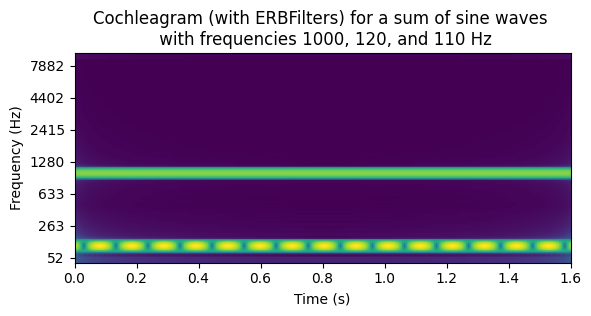

In [ ]:
# Build x as a sum of a few sine waves.
freq = 1000
time_x = np.arange(0, signal_size)/20000;
# Amplitude of the sine wave is sine of a variable like time
amplitude = np.sin(2 * np.pi * freq * time_x)

# These two frequencies will show some beating in the cochleagram.
freq2 = 120
amplitude += np.sin(2 * np.pi * freq2 * time_x)
freq3 = 110
amplitude += np.sin(2 * np.pi * freq3 * time_x)

# Add batch dimension.
amplitude = np.expand_dims(amplitude, 0)

# Convert to pytorch tensor.
x = ch.autograd.Variable(ch.Tensor(amplitude), requires_grad=True)

# Make the cochleagram
y = cochleagram(x)

# Plot the cochleagram
plt.imshow(np.squeeze(y.detach().numpy()), origin='lower', extent=(0, y.shape[2], 0, y.shape[1]))

plt.title('Cochleagram (with ERBFilters) for a sum of sine waves \n with frequencies %d, %d, and %d Hz'%(freq, freq2, freq3))

## Depending on the temporal padding the cochleagram length may not be exactly equal env_sr*signal_size/sr
# Because of this, set the x-axis tick labels based on the original audio.
num_ticks = 9
x_tick_numbers = [t_num*y.shape[-1]/(num_ticks-1) for t_num in range(num_ticks)]
x_tick_labels = [t_num*signal_size/sr/(num_ticks-1) for t_num in range(num_ticks)]
plt.xticks(x_tick_numbers, x_tick_labels)
plt.xlabel('Time (s)')

## Label the frequency axis based on the center frequencies for the ERB filters.
filters.filter_extras['cf']
# Use ticks starting at the lowest non-lowpass filter center frequency.
y_ticks = [y_t+3 for y_t in plt.yticks()[0] if y_t<=y.shape[1]]
plt.yticks(y_ticks, [int(round(filters.filter_extras['cf'][int(f_num)])) for f_num in y_ticks])
plt.ylabel('Frequency (Hz)')

### Generate the cochleagram from the fMRI music stimulus

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import glob

# Get a list of all the file paths that ends with .txt from in specified directory
file_list = glob.glob("/content/gdrive/MyDrive/fmri/tsv/*")

# sort and Print the file list
file_list.sort()
print(len(file_list))


18


In [ ]:

# extract a file
import pandas as pd
df = pd.read_csv(file_list[0], sep="\t")
# df[df["genre"]=="'metal'"]

In [ ]:
#Processing code for metal/country and many other genres can be done in a for loop
# run10 = []
# num_tracks = len(df[df["genre"]=="'metal'"]["track"])
# for i in range(num_tracks):
#     # extract a single signal
#     # get the sound track
#     stats = df[df["genre"]=="'metal'"].iloc[i]
#     track_num = str(stats["track"]).zfill(2)
#     signal_start = stats["start"]
#     signal_end = stats["end"]
#     #go to the folder
#     import librosa

#     filename = "/content/gdrive/MyDrive/fmri/genres/metal/metal.000"+ track_num+".wav"

#     # Load the .wav file
#     y, sr = librosa.load(filename, sr=None)
#     # Compute MFCCs for each audio file
#     #mfcc1 = librosa.feature.mfcc(y, sr)



#     # Convert time to samples
#     start_samples = librosa.time_to_samples(signal_start, sr=sr)
#     end_samples = librosa.time_to_samples(signal_end, sr=sr)

#     # Extract part
#     y_part = y[start_samples:end_samples]
#     #y_part=librosa.resample(y_part, orig_sr = sr,target_sr= 50)
#     run10.append(y_part)
# run10_blues = []
# num_tracks = len(df[df["genre"]=="'blues'"]["track"])
# for i in range(num_tracks):
#     # extract a single signal
#     # get the sound track
#     stats = df[df["genre"]=="'blues'"].iloc[i]
#     track_num = str(stats["track"]).zfill(2)
#     signal_start = stats["start"]
#     signal_end = stats["end"]
#     #go to the folder
#     import librosa

#     filename = "/content/gdrive/MyDrive/fmri/genres/blues/blues.000"+ track_num+".wav"

#     # Load the .wav file
#     y, sr = librosa.load(filename, sr=None)
#     print(sr)


#     # Convert time to samples
#     start_samples = librosa.time_to_samples(signal_start, sr=sr)
#     end_samples = librosa.time_to_samples(signal_end, sr=sr)

#     # Extract part
#     y_part = y[start_samples:end_samples]
#     #y_part=librosa.resample(y_part, orig_sr = sr,target_sr= 50)
#     run10_blues.append(y_part)
# run10_country = []
# num_tracks = len(df[df["genre"]=="'country'"]["track"])
# for i in range(num_tracks):
#     # extract a single signal
#     # get the sound track
#     stats = df[df["genre"]=="'country'"].iloc[i]
#     track_num = str(stats["track"]).zfill(2)
#     signal_start = stats["start"]
#     signal_end = stats["end"]
#     #go to the folder
#     import librosa

#     filename = "/content/gdrive/MyDrive/fmri/genres/country/country.000"+ track_num+".wav"

#     # Load the .wav file
#     y, sr = librosa.load(filename, sr=None)
#     print(sr)


#     # Convert time to samples
#     # start_samples = librosa.time_to_samples(signal_start, sr=sr)
#     # end_samples = librosa.time_to_samples(signal_end, sr=sr)
#     start_samples = librosa.time_to_samples(signal_start, sr=sr)
#     end_samples = librosa.time_to_samples(signal_end, sr=sr)
#     # Extract part
#     y_part = y[start_samples:end_samples]
#     #y_part=librosa.resample(y_part, orig_sr = sr,target_sr= 50)
#     run10_country.append(y_part)

### Processing code for country

In [ ]:
run10_country = []
num_tracks = len(df[df["genre"]=="'country'"]["track"])
for i in range(num_tracks):
    # extract a single signal
    # get the sound track
    stats = df[df["genre"]=="'country'"].iloc[i]
    track_num = str(stats["track"]).zfill(2)
    signal_start = stats["start"]
    signal_end = stats["end"]
    #go to the folder
    filename = "/content/gdrive/MyDrive/fmri/genres/country/country.000"+ track_num+".wav"

    # Load the .wav file
    y, sr = librosa.load(filename, sr=None)
    print(sr)


    # Convert time to samples
    # start_samples = librosa.time_to_samples(signal_start, sr=sr)
    # end_samples = librosa.time_to_samples(signal_end, sr=sr)
    start_samples = librosa.time_to_samples(signal_start, sr=sr)
    end_samples = librosa.time_to_samples(signal_end, sr=sr)
    # Extract part
    y_part = y[start_samples:end_samples]
    #y_part=librosa.resample(y_part, orig_sr = sr,target_sr= 50)
    run10_country.append(y_part)

22050
22050
22050
22050


Text(0, 0.5, 'Filter Magnitude')

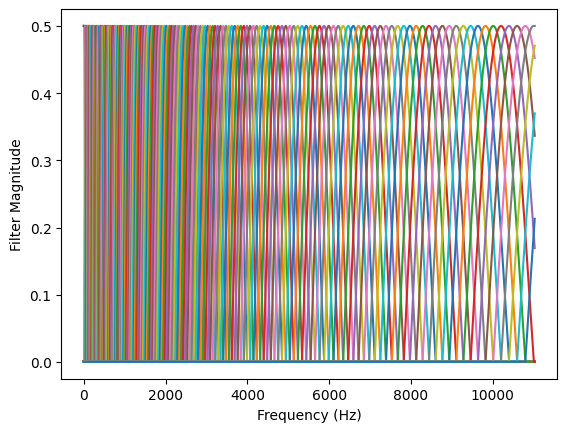

In [ ]:
### Args used for multiple stages of the cochleagram operations
signal_size = 330750 # Length of the input audio signal (currently must be fixed, due to filter construction)
sr = 22050 # Sampling rate of the input audio
pad_factor = 1 # Zero padding applied to the waveform, so the end signal is length pad_factor*signal_length
use_rfft = True # Whether to use rfft operations when appropriate (recommended)

### Define the cochlear filters using ERBCosFilters.
# These are the arguments used for filter construction of ERBCosFilters. See helpers/erb_filters.py for
# more documentation.
half_cos_filter_kwargs = {
    'n':50, # Number of filters to evenly tile the space
    'low_lim':30, # Lowest center frequency for full filter (if lowpass filters are used they can be centered lower)
    'high_lim':11000, # Highest center frequency
    'sample_factor':4, # Positive integer that determines how densely ERB function will be sampled
    'full_filter':False, # Whether to use the full-filter. Must be False if rFFT is true.
}

# half_cos_filter_kwargs = {
#     'n':30, # Number of filters to evenly tile the space
#     'low_lim':52, # Lowest center frequency for full filter (if lowpass filters are used they can be centered lower)
#     'high_lim':8844, # Highest center frequency
#     'sample_factor':4, # Positive integer that determines how densely ERB function will be sampled
#     'full_filter':False, # Whether to use the full-filter. Must be False if rFFT is true.
# }

# These arguments are for the CochFilters class (generic to any filters).
coch_filter_kwargs = {'use_rfft':use_rfft,
                      'pad_factor':pad_factor,
                      'filter_kwargs':half_cos_filter_kwargs}

# This (and most) cochleagrams use ERBCosFilters, however other types of filterbanks can be
# constructed for linear spaced filters or different shapes. Make a new CochlearFilter class for
# these.
filters = chcochleagram.cochlear_filters.ERBCosFilters(signal_size,
                                                       sr,
                                                       **coch_filter_kwargs)

### Look at the filters
# Filters are in form [filter_idx, frequency, (real_value, complex_value)] where for ERB filters
# the complex component is 0. Newer versions of pytorch have complex types, but complex values are
# represented with an extra dimension for now.
for f_idx in range(filters.coch_filters.shape[0]):
    plt.plot(filters.filter_extras['freqs'], filters.coch_filters[f_idx,:,0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter Magnitude')

In [ ]:
### Define an envelope extraction operation
# Use the analytic amplitude of the hilbert transform here. Other types of envelope extraction
# are also implemented in envelope_extraction.py. Can use Identity if want the raw subbands.
envelope_extraction = chcochleagram.envelope_extraction.HilbertEnvelopeExtraction(signal_size,
                                                                                  sr,
                                                                                  use_rfft,
                                                                                  pad_factor)

### Define a downsampling operation
# Downsample the extracted envelopes. Can use Identity if want the raw subbands.
env_sr = 2205 # Sampling rate after downsampling
downsampling_kwargs = {'window_size':1001} # Parameters for the downsampling filter (see downsampling.py)
downsampling_op = chcochleagram.downsampling.SincWithKaiserWindow(sr, env_sr, **downsampling_kwargs)

### Define a compression operation.
compression_kwargs = {'power':0.3, # Power compression of 0.3
                      'offset':1e-8, # Offset for numerical stability in backwards pass
                      'scale':1, # Optional multiplicative value applied to the envelopes before compression
                      'clip_value':100} # Clip the gradients for this compression for stability
compression = chcochleagram.compression.ClippedGradPowerCompression(**compression_kwargs)

In [ ]:
cochleagram = chcochleagram.cochleagram.Cochleagram(filters,
                                                    envelope_extraction,
                                                    downsampling_op,
                                                    compression=compression)

In [ ]:
# prompt: Get a pink noise signal
time_x = np.arange(0, signal_size)/sr;

# Add batch dimension.
amplitude = np.expand_dims(run10_country[0], 0)

# Convert to pytorch tensor.
x = ch.autograd.Variable(ch.Tensor(amplitude), requires_grad=True)

# Make the cochleagram
y = cochleagram(x)

# Plot the cochleagram



Text(0, 0.5, 'Frequency (Hz)')

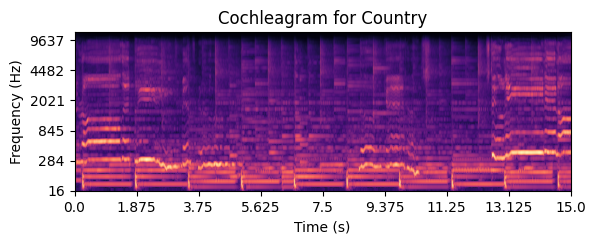

In [ ]:
# Plot the cochleagram
plt.imshow(np.squeeze(y.detach().numpy()), origin='lower', extent=(0, y.shape[2], 0, y.shape[1]*50), cmap='magma')

plt.title('Cochleagram for Country')

## Depending on the temporal padding the cochleagram length may not be exactly equal env_sr*signal_size/sr
# Because of this, set the x-axis tick labels based on the original audio.
num_ticks = 9
x_tick_numbers = [t_num*y.shape[-1]/(num_ticks-1) for t_num in range(num_ticks)]
x_tick_labels = [t_num*signal_size/sr/(num_ticks-1) for t_num in range(num_ticks)]
plt.xticks(x_tick_numbers, x_tick_labels)
plt.xlabel('Time (s)')

## Label the frequency axis based on the center frequencies for the ERB filters.
filters.filter_extras['cf']
# Use ticks starting at the lowest non-lowpass filter center frequency.
y_ticks = [y_t+3 for y_t in plt.yticks()[0] if y_t<=y.shape[1]*50]
plt.yticks(y_ticks, [int(round(filters.filter_extras['cf'][int(f_num/50)])) for f_num in y_ticks])
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

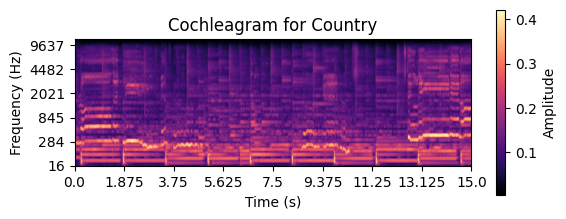

In [ ]:
# Plot the cochleagram
img = plt.imshow(np.squeeze(y.detach().numpy()), origin='lower', extent=(0, y.shape[2], 0, y.shape[1]*50), cmap='magma')
plt.colorbar(img, label='Amplitude',shrink=0.5)  # Add colorbar with label

plt.title('Cochleagram for Country')

# Depending on the temporal padding the cochleagram length may not be exactly equal env_sr*signal_size/sr
# Because of this, set the x-axis tick labels based on the original audio.
num_ticks = 9
x_tick_numbers = [t_num*y.shape[-1]/(num_ticks-1) for t_num in range(num_ticks)]
x_tick_labels = [t_num*signal_size/sr/(num_ticks-1) for t_num in range(num_ticks)]
plt.xticks(x_tick_numbers, x_tick_labels)
plt.xlabel('Time (s)')

# Label the frequency axis based on the center frequencies for the ERB filters.
filters.filter_extras['cf']
# Use ticks starting at the lowest non-lowpass filter center frequency.
y_ticks = [y_t+3 for y_t in plt.yticks()[0] if y_t<=y.shape[1]*50]
plt.yticks(y_ticks, [int(round(filters.filter_extras['cf'][int(f_num/50)])) for f_num in y_ticks])
plt.ylabel('Frequency (Hz)')

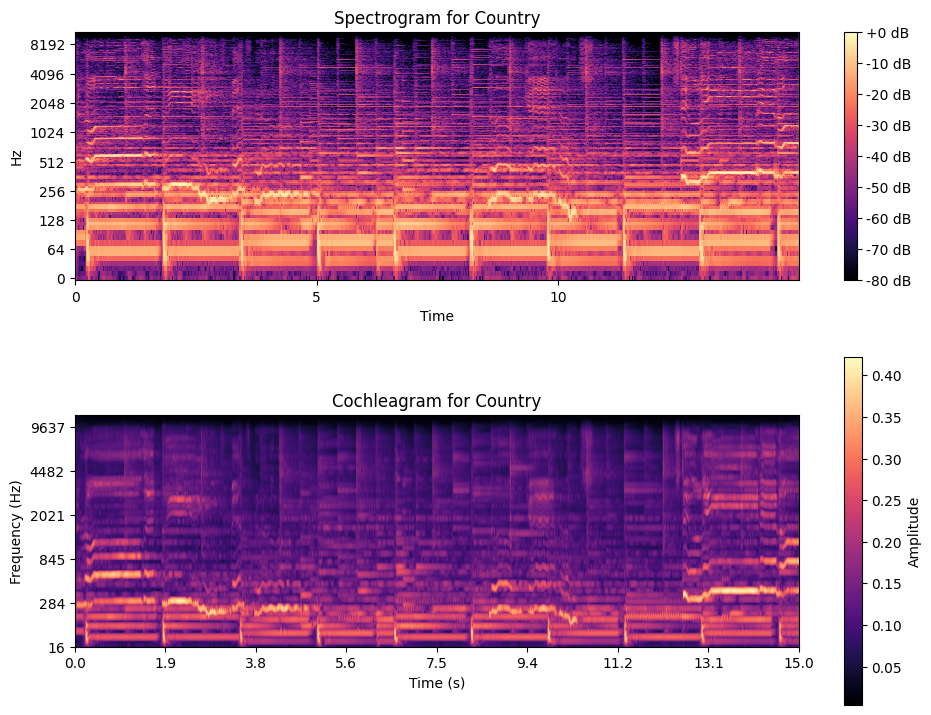

In [43]:
import matplotlib.pyplot as plt
import librosa.display

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8),
                    gridspec_kw={'height_ratios': [1, 2]})

# -------------------------------------
# Top plot: Librosa spectrogram
# -------------------------------------
D = librosa.stft(run10_country[0])
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Plot on first axis
img1 = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=ax1)
fig.colorbar(img1, ax=ax1, format='%+2.0f dB')
ax1.set_title('Spectrogram for Country')

# -------------------------------------
# Bottom plot: Cochleagram
# -------------------------------------
# Plot on second axis
img2 = ax2.imshow(np.squeeze(y.detach().numpy()),
                origin='lower',
                extent=(0, y.shape[2], 0, y.shape[1]*50),
                cmap='magma')

# Add colorbar to second axis
cbar = fig.colorbar(img2, ax=ax2, label='Amplitude', shrink=0.7)
ax2.set_title('Cochleagram for Country')

# Custom x-ticks for cochleagram
num_ticks = 9
x_tick_numbers = [t_num*y.shape[-1]/(num_ticks-1) for t_num in range(num_ticks)]
x_tick_labels = [f"{(t_num*signal_size/sr/(num_ticks-1)):.1f}"
                for t_num in range(num_ticks)]
ax2.set_xticks(x_tick_numbers)
ax2.set_xticklabels(x_tick_labels)
ax2.set_xlabel('Time (s)')

# Custom y-ticks for cochleagram
y_ticks = [y_t+3 for y_t in ax2.get_yticks() if y_t <= y.shape[1]*50]
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([int(round(filters.filter_extras['cf'][int(f_num/50)]))
                    for f_num in y_ticks])
ax2.set_ylabel('Frequency (Hz)')

# Adjust layout
plt.tight_layout()
plt.show()

### Previous code for processing rock

In [ ]:
run10_rock = []
num_tracks = len(df[df["genre"]=="'rock'"]["track"])
for i in range(num_tracks):
    # extract a single signal
    # get the sound track
    stats = df[df["genre"]=="'rock'"].iloc[i]
    track_num = str(stats["track"]).zfill(2)
    signal_start = stats["start"]
    signal_end = stats["end"]
    #go to the folder
    import librosa

    filename = "/content/gdrive/MyDrive/fmri/genres/rock/rock.000"+ track_num+".wav"

    # Load the .wav file
    y, sr = librosa.load(filename, sr=None)
    print(sr)


    # Convert time to samples
    # start_samples = librosa.time_to_samples(signal_start, sr=sr)
    # end_samples = librosa.time_to_samples(signal_end, sr=sr)
    start_samples = librosa.time_to_samples(signal_start, sr=sr)
    end_samples = librosa.time_to_samples(signal_end, sr=sr)
    # Extract part
    y_part = y[start_samples:end_samples]
    #y_part=librosa.resample(y_part, orig_sr = sr,target_sr= 50)
    run10_rock.append(y_part)

22050
22050
22050
22050


In [ ]:
run10_rock[0].shape

(330750,)

Text(0, 0.5, 'Filter Magnitude')

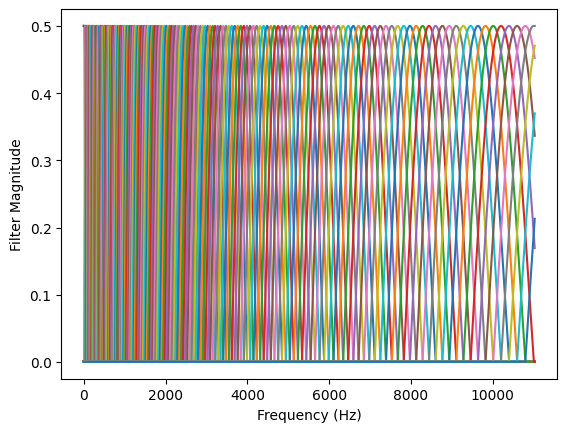

In [ ]:
### Args used for multiple stages of the cochleagram operations
signal_size = 330750 # Length of the input audio signal (currently must be fixed, due to filter construction)
sr = 22050 # Sampling rate of the input audio
pad_factor = 1 # Zero padding applied to the waveform, so the end signal is length pad_factor*signal_length
use_rfft = True # Whether to use rfft operations when appropriate (recommended)

### Define the cochlear filters using ERBCosFilters.
# These are the arguments used for filter construction of ERBCosFilters. See helpers/erb_filters.py for
# more documentation.
half_cos_filter_kwargs = {
    'n':50, # Number of filters to evenly tile the space
    'low_lim':30, # Lowest center frequency for full filter (if lowpass filters are used they can be centered lower)
    'high_lim':11000, # Highest center frequency
    'sample_factor':4, # Positive integer that determines how densely ERB function will be sampled
    'full_filter':False, # Whether to use the full-filter. Must be False if rFFT is true.
}

# half_cos_filter_kwargs = {
#     'n':30, # Number of filters to evenly tile the space
#     'low_lim':52, # Lowest center frequency for full filter (if lowpass filters are used they can be centered lower)
#     'high_lim':8844, # Highest center frequency
#     'sample_factor':4, # Positive integer that determines how densely ERB function will be sampled
#     'full_filter':False, # Whether to use the full-filter. Must be False if rFFT is true.
# }

# These arguments are for the CochFilters class (generic to any filters).
coch_filter_kwargs = {'use_rfft':use_rfft,
                      'pad_factor':pad_factor,
                      'filter_kwargs':half_cos_filter_kwargs}

# This (and most) cochleagrams use ERBCosFilters, however other types of filterbanks can be
# constructed for linear spaced filters or different shapes. Make a new CochlearFilter class for
# these.
filters = chcochleagram.cochlear_filters.ERBCosFilters(signal_size,
                                                       sr,
                                                       **coch_filter_kwargs)

### Look at the filters
# Filters are in form [filter_idx, frequency, (real_value, complex_value)] where for ERB filters
# the complex component is 0. Newer versions of pytorch have complex types, but complex values are
# represented with an extra dimension for now.
for f_idx in range(filters.coch_filters.shape[0]):
    plt.plot(filters.filter_extras['freqs'], filters.coch_filters[f_idx,:,0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter Magnitude')

In [ ]:
### Define an envelope extraction operation
# Use the analytic amplitude of the hilbert transform here. Other types of envelope extraction
# are also implemented in envelope_extraction.py. Can use Identity if want the raw subbands.
envelope_extraction = chcochleagram.envelope_extraction.HilbertEnvelopeExtraction(signal_size,
                                                                                  sr,
                                                                                  use_rfft,
                                                                                  pad_factor)

### Define a downsampling operation
# Downsample the extracted envelopes. Can use Identity if want the raw subbands.
env_sr = 2205 # Sampling rate after downsampling
downsampling_kwargs = {'window_size':1001} # Parameters for the downsampling filter (see downsampling.py)
downsampling_op = chcochleagram.downsampling.SincWithKaiserWindow(sr, env_sr, **downsampling_kwargs)

### Define a compression operation.
compression_kwargs = {'power':0.3, # Power compression of 0.3
                      'offset':1e-8, # Offset for numerical stability in backwards pass
                      'scale':1, # Optional multiplicative value applied to the envelopes before compression
                      'clip_value':100} # Clip the gradients for this compression for stability
compression = chcochleagram.compression.ClippedGradPowerCompression(**compression_kwargs)

In [ ]:
cochleagram = chcochleagram.cochleagram.Cochleagram(filters,
                                                    envelope_extraction,
                                                    downsampling_op,
                                                    compression=compression)

IndexError: index 2003 is out of bounds for axis 0 with size 211

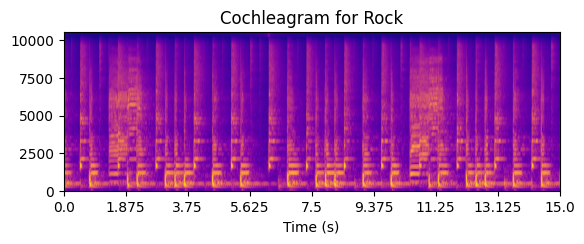

In [ ]:
# prompt: Get a pink noise signal
time_x = np.arange(0, signal_size)/sr;

# Add batch dimension.
amplitude = np.expand_dims(run10_rock[0], 0)

# Convert to pytorch tensor.
x = ch.autograd.Variable(ch.Tensor(amplitude), requires_grad=True)

# Make the cochleagram
y = cochleagram(x)

# Plot the cochleagram
plt.imshow(np.squeeze(y.detach().numpy()), origin='lower', extent=(0, y.shape[2], 0, y.shape[1]*50), cmap='plasma')

plt.title('Cochleagram for Rock')

## Depending on the temporal padding the cochleagram length may not be exactly equal env_sr*signal_size/sr
# Because of this, set the x-axis tick labels based on the original audio.
num_ticks = 9
x_tick_numbers = [t_num*y.shape[-1]/(num_ticks-1) for t_num in range(num_ticks)]
x_tick_labels = [t_num*signal_size/sr/(num_ticks-1) for t_num in range(num_ticks)]
plt.xticks(x_tick_numbers, x_tick_labels)
plt.xlabel('Time (s)')

## Label the frequency axis based on the center frequencies for the ERB filters.
filters.filter_extras['cf']
# Use ticks starting at the lowest non-lowpass filter center frequency.
y_ticks = [y_t+3 for y_t in plt.yticks()[0] if y_t<=y.shape[1]*50]
plt.yticks(y_ticks, [int(round(filters.filter_extras['cf'][int(f_num)])) for f_num in y_ticks])
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

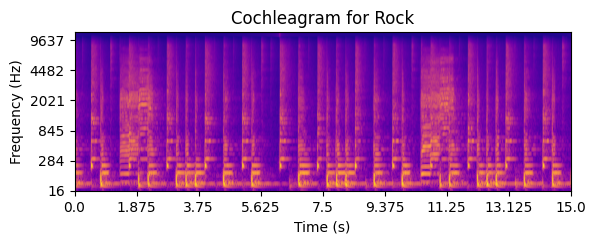

In [ ]:
# Plot the cochleagram
plt.imshow(np.squeeze(y.detach().numpy()), origin='lower', extent=(0, y.shape[2], 0, y.shape[1]*50), cmap='plasma')

plt.title('Cochleagram for Rock')

## Depending on the temporal padding the cochleagram length may not be exactly equal env_sr*signal_size/sr
# Because of this, set the x-axis tick labels based on the original audio.
num_ticks = 9
x_tick_numbers = [t_num*y.shape[-1]/(num_ticks-1) for t_num in range(num_ticks)]
x_tick_labels = [t_num*signal_size/sr/(num_ticks-1) for t_num in range(num_ticks)]
plt.xticks(x_tick_numbers, x_tick_labels)
plt.xlabel('Time (s)')

## Label the frequency axis based on the center frequencies for the ERB filters.
filters.filter_extras['cf']
# Use ticks starting at the lowest non-lowpass filter center frequency.
y_ticks = [y_t+3 for y_t in plt.yticks()[0] if y_t<=y.shape[1]*50]
plt.yticks(y_ticks, [int(round(filters.filter_extras['cf'][int(f_num/50)])) for f_num in y_ticks])
plt.ylabel('Frequency (Hz)')

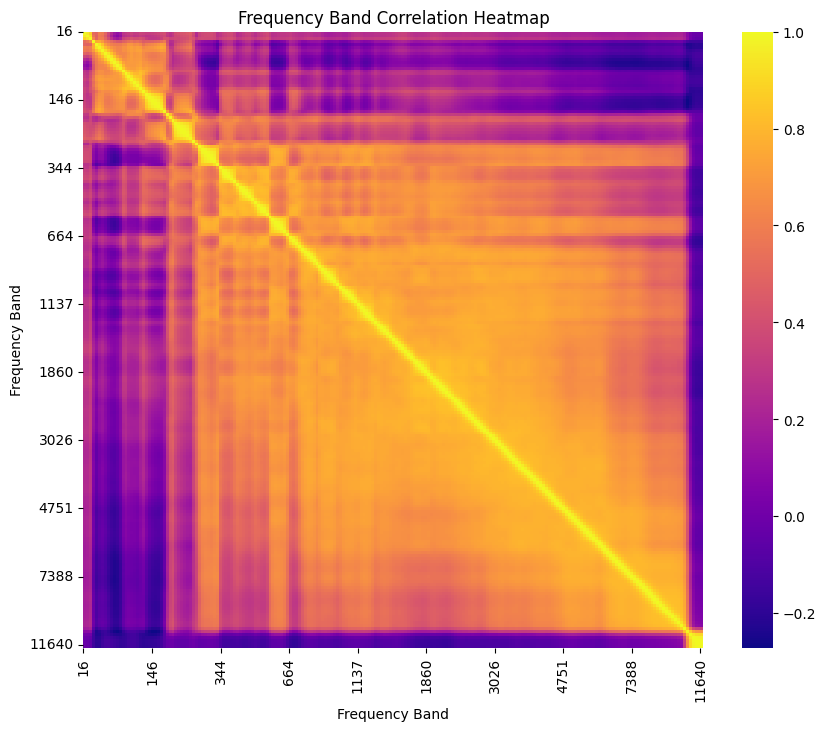

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y' is your cochleagram data (from previous code)

# Compute frequency band correlation
correlation_matrix = np.corrcoef(np.squeeze(y.detach().numpy()))

# Get the number of frequency bands in your filterbank
num_frequency_bands = filters.filter_extras['cf'].shape[0]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='plasma', fmt=".2f")
plt.title('Frequency Band Correlation Heatmap')
plt.xlabel('Frequency Band')
plt.ylabel('Frequency Band')

# Adjust y-axis ticks to match the frequency band range
y_ticks = np.linspace(0, num_frequency_bands - 1, 10)  # Example: 6 ticks
y_tick_labels = [int(round(filters.filter_extras['cf'][int(f_num)])) for f_num in y_ticks]
plt.yticks(y_ticks, y_tick_labels)
plt.xticks(y_ticks, y_tick_labels)

plt.show()